In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lhds3j4w
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lhds3j4w
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=22a98c518ca63d508f6ea1e74c6f64c2f13ddeb46cf8f08e4c637afbe60076ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-v9un2gln/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import clip
import numpy as np

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model_vit, preprocess_vit = clip.load("ViT-B/16")
model_rn, preprocess_rn = clip.load("RN50x16")

100%|███████████████████████████████████████| 335M/335M [00:07<00:00, 47.9MiB/s]
100%|███████████████████████████████████████| 630M/630M [00:53<00:00, 12.4MiB/s]


In [4]:
model_vit, preprocess_vit = clip.load("ViT-B/16")


100%|███████████████████████████████████████| 335M/335M [00:05<00:00, 61.1MiB/s]


In [5]:
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from PIL import Image
import os

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_vit= model_vit.to(device)
#model_vit, model_rn = model_vit.to(device), model_rn.to(device)

In [8]:
device

'cuda'

In [ ]:
def load_cifar10(preprocess, batch_size=32):
    dataset = CIFAR10(root="./data", train=False, download=True, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader, dataset.classes

batch_size = 32
dataloader_vit, class_names = load_cifar10(preprocess_vit, batch_size)
dataloader_rn, _ = load_cifar10(preprocess_rn, batch_size)

100%|██████████| 170M/170M [00:18<00:00, 9.11MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
from torchvision.datasets import Places365


In [13]:
places_dataset = Places365(
    root="places365",
    split="val",
    small=True,
    transform=preprocess_vit,
    download=True
)

places_loader = DataLoader(places_dataset, batch_size=32, shuffle=False)

100%|██████████| 67.5M/67.5M [00:01<00:00, 36.6MB/s]


Extracting places365/filelist_places365-standard.tar to places365


100%|██████████| 525M/525M [00:11<00:00, 46.3MB/s]


Extracting places365/val_256.tar to places365


In [14]:
class_names = places_dataset.classes

In [18]:
text_tokens = clip.tokenize([f"This is a photo of a {label}" for label in class_names]).to(device)

with torch.no_grad():
    text_features_vit = model_vit.encode_text(text_tokens).float()
    text_features_vit /= text_features_vit.norm(dim=-1, keepdim=True)

    # text_features_rn = model_rn.encode_text(text_tokens).float()
    # text_features_rn /= text_features_rn.norm(dim=-1, keepdim=True)

In [16]:
from tqdm import tqdm
import time

In [19]:
all_labels = []
predictions_vit = []
predictions_rn = []
for (images_vit, labels)in tqdm(places_loader):
    start = time.time()
    images_vit = images_vit.to(device)
    labels = labels.to(device)
    all_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
      image_features_vit = model_vit.encode_image(images_vit).float()
      image_features_vit /= image_features_vit.norm(dim=-1, keepdim=True)

      text_probs_vit = (100.0 * image_features_vit @ text_features_vit.T).softmax(dim=-1)
      predictions_vit.extend(text_probs_vit.argmax(dim=-1))
    end = time.time()
    print(end - start)

  0%|          | 2/1141 [00:01<08:26,  2.25it/s]

0.7248308658599854
0.013213872909545898


  0%|          | 4/1141 [00:01<04:11,  4.52it/s]

0.025622129440307617
0.015870332717895508


  1%|          | 6/1141 [00:01<02:56,  6.41it/s]

0.013605594635009766
0.012927055358886719


  1%|          | 8/1141 [00:01<02:31,  7.46it/s]

0.013387918472290039
0.013454914093017578


  1%|          | 10/1141 [00:01<02:14,  8.38it/s]

0.013756275177001953
0.013134002685546875


  1%|          | 12/1141 [00:02<02:08,  8.76it/s]

0.014430522918701172
0.013414144515991211


  1%|          | 14/1141 [00:02<02:10,  8.61it/s]

0.014400959014892578
0.013947725296020508


  1%|▏         | 16/1141 [00:02<02:09,  8.67it/s]

0.01368260383605957
0.017790794372558594


  2%|▏         | 18/1141 [00:02<02:06,  8.89it/s]

0.013607501983642578
0.013919591903686523


  2%|▏         | 20/1141 [00:03<02:14,  8.36it/s]

0.02116703987121582
0.013918638229370117


  2%|▏         | 22/1141 [00:03<02:09,  8.65it/s]

0.013946294784545898
0.01729893684387207


  2%|▏         | 23/1141 [00:03<02:15,  8.25it/s]

0.016592025756835938


  2%|▏         | 24/1141 [00:03<03:53,  4.77it/s]

0.030469179153442383


  2%|▏         | 26/1141 [00:04<03:24,  5.44it/s]

0.013310670852661133
0.013654232025146484


  2%|▏         | 28/1141 [00:04<02:43,  6.81it/s]

0.02257561683654785
0.013362646102905273


  3%|▎         | 29/1141 [00:04<02:45,  6.71it/s]

0.031009912490844727


  3%|▎         | 31/1141 [00:05<03:59,  4.64it/s]

0.02104806900024414
0.013875246047973633


  3%|▎         | 33/1141 [00:05<03:03,  6.03it/s]

0.013927221298217773
0.013738870620727539


  3%|▎         | 34/1141 [00:05<02:43,  6.76it/s]

0.013524293899536133


  3%|▎         | 35/1141 [00:05<03:46,  4.89it/s]

0.05716967582702637


  3%|▎         | 37/1141 [00:06<03:37,  5.09it/s]

0.017961978912353516
0.013365983963012695


  3%|▎         | 39/1141 [00:06<02:48,  6.54it/s]

0.013506889343261719
0.013350248336791992


  4%|▎         | 41/1141 [00:06<02:21,  7.75it/s]

0.014990568161010742
0.013562202453613281


  4%|▍         | 43/1141 [00:06<02:12,  8.27it/s]

0.013905048370361328
0.014602184295654297


  4%|▍         | 45/1141 [00:07<02:06,  8.64it/s]

0.013784408569335938
0.013431787490844727


  4%|▍         | 47/1141 [00:07<02:05,  8.73it/s]

0.014498710632324219
0.013643980026245117


  4%|▍         | 49/1141 [00:07<02:01,  8.99it/s]

0.013493061065673828
0.013738155364990234


  4%|▍         | 51/1141 [00:07<02:05,  8.67it/s]

0.014819145202636719
0.013422012329101562


  5%|▍         | 53/1141 [00:08<02:03,  8.84it/s]

0.013434648513793945
0.013821601867675781


  5%|▍         | 55/1141 [00:08<01:58,  9.14it/s]

0.014160394668579102
0.01367807388305664


  5%|▍         | 57/1141 [00:08<01:59,  9.07it/s]

0.013367176055908203
0.012929201126098633


  5%|▌         | 59/1141 [00:08<01:58,  9.14it/s]

0.015060186386108398
0.013476133346557617


  5%|▌         | 61/1141 [00:08<02:02,  8.83it/s]

0.01792287826538086
0.01428532600402832


  6%|▌         | 63/1141 [00:09<02:01,  8.89it/s]

0.013598918914794922
0.013892412185668945


  6%|▌         | 65/1141 [00:09<02:02,  8.76it/s]

0.014183282852172852
0.013392925262451172


  6%|▌         | 67/1141 [00:09<01:58,  9.04it/s]

0.014578819274902344
0.013939142227172852


  6%|▌         | 69/1141 [00:09<01:59,  8.96it/s]

0.013972759246826172
0.019939661026000977


  6%|▌         | 71/1141 [00:10<02:00,  8.85it/s]

0.013909101486206055
0.013402938842773438


  6%|▋         | 73/1141 [00:10<01:58,  8.99it/s]

0.013654708862304688
0.013598203659057617


  7%|▋         | 75/1141 [00:10<01:59,  8.89it/s]

0.01421499252319336
0.013594388961791992


  7%|▋         | 77/1141 [00:10<02:17,  7.71it/s]

0.020306110382080078
0.01938939094543457


  7%|▋         | 79/1141 [00:11<02:34,  6.88it/s]

0.016455650329589844
0.01872539520263672


  7%|▋         | 81/1141 [00:11<02:44,  6.45it/s]

0.016381263732910156
0.016217708587646484


  7%|▋         | 83/1141 [00:11<02:46,  6.36it/s]

0.016124486923217773
0.015612363815307617


  7%|▋         | 85/1141 [00:12<02:47,  6.30it/s]

0.016440629959106445
0.015710115432739258


  8%|▊         | 87/1141 [00:12<02:49,  6.21it/s]

0.01961994171142578
0.015856504440307617


  8%|▊         | 89/1141 [00:12<02:46,  6.32it/s]

0.019830942153930664
0.017997026443481445


  8%|▊         | 91/1141 [00:13<02:53,  6.06it/s]

0.018703460693359375
0.018267393112182617


  8%|▊         | 93/1141 [00:13<02:52,  6.08it/s]

0.020025014877319336
0.019228696823120117


  8%|▊         | 95/1141 [00:13<02:42,  6.44it/s]

0.026523590087890625
0.013329505920410156


  8%|▊         | 96/1141 [00:13<02:34,  6.77it/s]

0.020921945571899414


  9%|▊         | 98/1141 [00:14<02:42,  6.40it/s]

0.023018836975097656
0.013839483261108398


  9%|▉         | 100/1141 [00:14<02:20,  7.40it/s]

0.013746500015258789
0.013404369354248047


  9%|▉         | 102/1141 [00:14<02:28,  7.01it/s]

0.013428926467895508
0.021409988403320312


  9%|▉         | 104/1141 [00:14<02:21,  7.34it/s]

0.013441085815429688
0.01602029800415039


  9%|▉         | 106/1141 [00:15<02:45,  6.24it/s]

0.019451379776000977
0.013494491577148438


  9%|▉         | 108/1141 [00:15<02:19,  7.43it/s]

0.013481378555297852
0.0164029598236084


 10%|▉         | 110/1141 [00:15<02:05,  8.19it/s]

0.01651597023010254
0.0172579288482666


 10%|▉         | 112/1141 [00:16<02:01,  8.45it/s]

0.014527320861816406
0.01383209228515625


 10%|▉         | 114/1141 [00:16<01:57,  8.72it/s]

0.013615131378173828
0.013324260711669922


 10%|█         | 116/1141 [00:16<01:55,  8.84it/s]

0.013303756713867188
0.013233661651611328


 10%|█         | 118/1141 [00:16<01:52,  9.08it/s]

0.0158538818359375
0.014526605606079102


 11%|█         | 120/1141 [00:16<01:52,  9.09it/s]

0.01482081413269043
0.014007806777954102


 11%|█         | 122/1141 [00:17<01:52,  9.09it/s]

0.013800859451293945
0.018904447555541992


 11%|█         | 124/1141 [00:17<01:53,  8.97it/s]

0.014335870742797852
0.015467643737792969


 11%|█         | 126/1141 [00:17<01:50,  9.16it/s]

0.013060569763183594
0.013539314270019531


 11%|█         | 128/1141 [00:17<01:51,  9.09it/s]

0.017400264739990234
0.015041112899780273


 11%|█▏        | 130/1141 [00:17<01:51,  9.04it/s]

0.015537023544311523
0.017208576202392578


 12%|█▏        | 132/1141 [00:18<01:53,  8.88it/s]

0.013531208038330078
0.01392221450805664


 12%|█▏        | 134/1141 [00:18<01:52,  8.92it/s]

0.015190601348876953
0.013436079025268555


 12%|█▏        | 136/1141 [00:18<01:50,  9.06it/s]

0.016359329223632812
0.014760732650756836


 12%|█▏        | 138/1141 [00:18<01:50,  9.10it/s]

0.017661571502685547
0.013456106185913086


 12%|█▏        | 140/1141 [00:19<01:51,  8.96it/s]

0.015651941299438477
0.01347970962524414


 12%|█▏        | 142/1141 [00:19<01:55,  8.67it/s]

0.013730049133300781
0.013339519500732422


 13%|█▎        | 144/1141 [00:19<01:50,  9.01it/s]

0.013437509536743164
0.013611316680908203


 13%|█▎        | 146/1141 [00:19<01:49,  9.06it/s]

0.015190839767456055
0.013799905776977539


 13%|█▎        | 148/1141 [00:20<01:51,  8.91it/s]

0.014428377151489258
0.014704704284667969


 13%|█▎        | 150/1141 [00:20<01:51,  8.89it/s]

0.013309240341186523
0.013508081436157227


 13%|█▎        | 152/1141 [00:20<01:51,  8.86it/s]

0.013166189193725586
0.013386249542236328


 13%|█▎        | 154/1141 [00:20<01:50,  8.90it/s]

0.015521049499511719
0.01407766342163086


 14%|█▎        | 156/1141 [00:20<01:50,  8.90it/s]

0.014672279357910156
0.013882160186767578


 14%|█▍        | 158/1141 [00:21<01:50,  8.88it/s]

0.016262292861938477
0.01708984375


 14%|█▍        | 160/1141 [00:21<01:52,  8.72it/s]

0.013575077056884766
0.013227462768554688


 14%|█▍        | 162/1141 [00:21<01:50,  8.90it/s]

0.013699054718017578
0.01346588134765625


 14%|█▍        | 164/1141 [00:21<01:48,  8.96it/s]

0.01388406753540039
0.01670217514038086


 15%|█▍        | 166/1141 [00:22<01:49,  8.87it/s]

0.01386260986328125
0.013362884521484375


 15%|█▍        | 168/1141 [00:22<01:49,  8.85it/s]

0.01382756233215332
0.020578384399414062


 15%|█▍        | 170/1141 [00:22<01:50,  8.76it/s]

0.016860246658325195
0.013443708419799805


 15%|█▌        | 172/1141 [00:22<01:49,  8.87it/s]

0.014966964721679688
0.013906240463256836


 15%|█▌        | 174/1141 [00:22<01:47,  8.97it/s]

0.013746261596679688
0.014189958572387695


 15%|█▌        | 176/1141 [00:23<01:49,  8.81it/s]

0.013825178146362305
0.01345515251159668


 16%|█▌        | 178/1141 [00:23<01:52,  8.59it/s]

0.029609203338623047
0.013429403305053711


 16%|█▌        | 180/1141 [00:23<01:56,  8.25it/s]

0.014083385467529297
0.018880605697631836


 16%|█▌        | 182/1141 [00:24<02:19,  6.87it/s]

0.02002716064453125
0.024690628051757812


 16%|█▌        | 184/1141 [00:24<02:32,  6.26it/s]

0.01629328727722168
0.01939845085144043


 16%|█▋        | 186/1141 [00:24<02:32,  6.25it/s]

0.01848602294921875
0.01668834686279297


 16%|█▋        | 188/1141 [00:25<02:36,  6.09it/s]

0.01604318618774414
0.01796865463256836


 17%|█▋        | 190/1141 [00:25<02:36,  6.08it/s]

0.018772125244140625
0.01667308807373047


 17%|█▋        | 192/1141 [00:25<02:34,  6.15it/s]

0.019652128219604492
0.01748824119567871


 17%|█▋        | 194/1141 [00:25<02:33,  6.16it/s]

0.020650148391723633
0.0178680419921875


 17%|█▋        | 196/1141 [00:26<02:38,  5.96it/s]

0.019354820251464844
0.019946575164794922


 17%|█▋        | 198/1141 [00:26<02:39,  5.92it/s]

0.021169185638427734
0.01648879051208496


 18%|█▊        | 200/1141 [00:26<02:10,  7.20it/s]

0.013495445251464844
0.01671886444091797


 18%|█▊        | 202/1141 [00:27<01:57,  8.02it/s]

0.013808012008666992
0.013957977294921875


 18%|█▊        | 204/1141 [00:27<01:51,  8.37it/s]

0.014271974563598633
0.01368403434753418


 18%|█▊        | 206/1141 [00:27<01:49,  8.55it/s]

0.01360321044921875
0.014417648315429688


 18%|█▊        | 208/1141 [00:27<01:46,  8.78it/s]

0.01392221450805664
0.014023542404174805


 18%|█▊        | 210/1141 [00:28<01:46,  8.78it/s]

0.013788700103759766
0.014681577682495117


 19%|█▊        | 212/1141 [00:28<01:45,  8.84it/s]

0.01414632797241211
0.013498067855834961


 19%|█▉        | 214/1141 [00:28<01:45,  8.81it/s]

0.013794183731079102
0.013285160064697266


 19%|█▉        | 216/1141 [00:28<01:45,  8.78it/s]

0.01353597640991211
0.013536214828491211


 19%|█▉        | 218/1141 [00:28<01:42,  8.98it/s]

0.014734745025634766
0.013388872146606445


 19%|█▉        | 220/1141 [00:29<01:42,  8.97it/s]

0.01672816276550293
0.013704299926757812


 19%|█▉        | 222/1141 [00:29<01:45,  8.72it/s]

0.014783382415771484
0.013436079025268555


 20%|█▉        | 224/1141 [00:29<01:44,  8.75it/s]

0.013605594635009766
0.013544321060180664


 20%|█▉        | 226/1141 [00:29<01:42,  8.96it/s]

0.013663768768310547
0.013943910598754883


 20%|█▉        | 228/1141 [00:30<01:43,  8.83it/s]

0.014942646026611328
0.013938426971435547


 20%|██        | 230/1141 [00:30<01:39,  9.12it/s]

0.013370037078857422
0.013637781143188477


 20%|██        | 232/1141 [00:30<01:42,  8.86it/s]

0.013490676879882812
0.013412237167358398


 21%|██        | 234/1141 [00:30<01:42,  8.82it/s]

0.013779401779174805
0.013601303100585938


 21%|██        | 236/1141 [00:30<01:40,  9.00it/s]

0.01497793197631836
0.014356136322021484


 21%|██        | 238/1141 [00:31<01:40,  9.00it/s]

0.013535499572753906
0.014509201049804688


 21%|██        | 240/1141 [00:31<01:41,  8.85it/s]

0.01883387565612793
0.013636350631713867


 21%|██        | 242/1141 [00:31<01:40,  8.92it/s]

0.013213157653808594
0.013575315475463867


 21%|██▏       | 244/1141 [00:31<01:40,  8.89it/s]

0.013546466827392578
0.017575502395629883


 22%|██▏       | 246/1141 [00:32<01:40,  8.94it/s]

0.013295412063598633
0.014402389526367188


 22%|██▏       | 248/1141 [00:32<01:40,  8.93it/s]

0.014119148254394531
0.0173032283782959


 22%|██▏       | 250/1141 [00:32<01:38,  9.01it/s]

0.013345718383789062
0.013344287872314453


 22%|██▏       | 252/1141 [00:32<01:41,  8.80it/s]

0.01354217529296875
0.016214609146118164


 22%|██▏       | 254/1141 [00:32<01:39,  8.88it/s]

0.013978958129882812
0.014027833938598633


 22%|██▏       | 256/1141 [00:33<01:40,  8.77it/s]

0.013822793960571289
0.013582706451416016


 23%|██▎       | 258/1141 [00:33<01:40,  8.78it/s]

0.017070531845092773
0.013298988342285156


 23%|██▎       | 260/1141 [00:33<01:41,  8.69it/s]

0.013785123825073242
0.01380777359008789


 23%|██▎       | 262/1141 [00:33<01:38,  8.93it/s]

0.013796091079711914
0.013795614242553711


 23%|██▎       | 264/1141 [00:34<01:42,  8.55it/s]

0.016788721084594727
0.013597249984741211


 23%|██▎       | 266/1141 [00:34<01:42,  8.56it/s]

0.0133209228515625
0.014544248580932617


 23%|██▎       | 268/1141 [00:34<01:39,  8.73it/s]

0.016107797622680664
0.013281583786010742


 24%|██▎       | 270/1141 [00:34<01:40,  8.64it/s]

0.013733386993408203
0.013919591903686523


 24%|██▍       | 272/1141 [00:35<01:39,  8.74it/s]

0.015599727630615234
0.013689994812011719


 24%|██▍       | 274/1141 [00:35<01:37,  8.87it/s]

0.013763904571533203
0.01681995391845703


 24%|██▍       | 276/1141 [00:35<01:37,  8.86it/s]

0.013666152954101562
0.013815641403198242


 24%|██▍       | 278/1141 [00:35<01:38,  8.73it/s]

0.015318870544433594
0.013809442520141602


 25%|██▍       | 280/1141 [00:35<01:37,  8.80it/s]

0.014116048812866211
0.013471126556396484


 25%|██▍       | 282/1141 [00:36<01:36,  8.89it/s]

0.015605688095092773
0.013660192489624023


 25%|██▍       | 284/1141 [00:36<01:37,  8.76it/s]

0.021492958068847656
0.013478994369506836


 25%|██▌       | 286/1141 [00:36<01:38,  8.72it/s]

0.01613020896911621
0.013435125350952148


 25%|██▌       | 288/1141 [00:36<01:59,  7.12it/s]

0.020077943801879883
0.020205974578857422


 25%|██▌       | 290/1141 [00:37<02:10,  6.50it/s]

0.019816160202026367
0.017099618911743164


 26%|██▌       | 292/1141 [00:37<02:13,  6.38it/s]

0.018487930297851562
0.019740819931030273


 26%|██▌       | 294/1141 [00:37<02:17,  6.18it/s]

0.01921534538269043
0.017125606536865234


 26%|██▌       | 296/1141 [00:38<02:20,  6.00it/s]

0.016067028045654297
0.021720170974731445


 26%|██▌       | 298/1141 [00:38<02:20,  6.01it/s]

0.01727890968322754
0.021749496459960938


 26%|██▋       | 300/1141 [00:39<02:21,  5.93it/s]

0.020219802856445312
0.022492170333862305


 26%|██▋       | 302/1141 [00:39<02:21,  5.91it/s]

0.018007993698120117
0.022296667098999023


 27%|██▋       | 304/1141 [00:39<02:21,  5.90it/s]

0.020410537719726562
0.019766807556152344


 27%|██▋       | 305/1141 [00:39<02:13,  6.28it/s]

0.013811588287353516


 27%|██▋       | 306/1141 [00:40<02:28,  5.62it/s]

0.045499324798583984


 27%|██▋       | 308/1141 [00:40<02:58,  4.65it/s]

0.0385737419128418
0.013517379760742188


 27%|██▋       | 310/1141 [00:40<02:15,  6.11it/s]

0.01407766342163086
0.014878273010253906


 27%|██▋       | 312/1141 [00:41<01:55,  7.15it/s]

0.01388096809387207
0.017384767532348633


 28%|██▊       | 314/1141 [00:41<01:44,  7.94it/s]

0.013795137405395508
0.013394355773925781


 28%|██▊       | 316/1141 [00:41<01:39,  8.31it/s]

0.013892412185668945
0.013738870620727539


 28%|██▊       | 318/1141 [00:41<01:35,  8.62it/s]

0.013911962509155273
0.013575553894042969


 28%|██▊       | 320/1141 [00:41<01:35,  8.59it/s]

0.014883041381835938
0.014031410217285156


 28%|██▊       | 322/1141 [00:42<01:34,  8.66it/s]

0.015346050262451172
0.013889551162719727


 28%|██▊       | 324/1141 [00:42<01:34,  8.63it/s]

0.018854141235351562
0.013532638549804688


 29%|██▊       | 326/1141 [00:42<01:32,  8.79it/s]

0.014219522476196289
0.014818906784057617


 29%|██▊       | 328/1141 [00:42<01:31,  8.91it/s]

0.01586174964904785
0.014368772506713867


 29%|██▉       | 330/1141 [00:43<01:32,  8.77it/s]

0.013634920120239258
0.013782501220703125


 29%|██▉       | 332/1141 [00:43<01:32,  8.72it/s]

0.013437747955322266
0.016434431076049805


 29%|██▉       | 334/1141 [00:43<01:30,  8.94it/s]

0.01381683349609375
0.01344156265258789


 29%|██▉       | 336/1141 [00:43<01:28,  9.13it/s]

0.014946699142456055
0.013312101364135742


 30%|██▉       | 338/1141 [00:44<01:31,  8.74it/s]

0.013509511947631836
0.015506982803344727


 30%|██▉       | 340/1141 [00:44<01:31,  8.80it/s]

0.01450967788696289
0.016506433486938477


 30%|██▉       | 342/1141 [00:44<01:32,  8.68it/s]

0.01444864273071289
0.013602256774902344


 30%|███       | 344/1141 [00:44<01:30,  8.84it/s]

0.014111757278442383
0.016463041305541992


 30%|███       | 346/1141 [00:44<01:29,  8.90it/s]

0.014569282531738281
0.014094829559326172


 30%|███       | 348/1141 [00:45<01:32,  8.57it/s]

0.01369786262512207
0.013981103897094727


 31%|███       | 350/1141 [00:45<01:32,  8.58it/s]

0.014228343963623047
0.013568401336669922


 31%|███       | 352/1141 [00:45<01:30,  8.73it/s]

0.013835906982421875
0.013708829879760742


 31%|███       | 354/1141 [00:45<01:29,  8.79it/s]

0.01405787467956543
0.014073610305786133


 31%|███       | 356/1141 [00:46<01:31,  8.56it/s]

0.014487266540527344
0.013951778411865234


 31%|███▏      | 358/1141 [00:46<01:30,  8.64it/s]

0.013683080673217773
0.01718878746032715


 32%|███▏      | 360/1141 [00:46<01:28,  8.78it/s]

0.01363825798034668
0.013728618621826172


 32%|███▏      | 362/1141 [00:46<01:27,  8.87it/s]

0.013719320297241211
0.01418447494506836


 32%|███▏      | 364/1141 [00:46<01:27,  8.91it/s]

0.014178991317749023
0.013872861862182617


 32%|███▏      | 366/1141 [00:47<01:28,  8.71it/s]

0.01451873779296875
0.013721704483032227


 32%|███▏      | 368/1141 [00:47<01:29,  8.67it/s]

0.01745915412902832
0.013615131378173828


 32%|███▏      | 370/1141 [00:47<01:26,  8.89it/s]

0.014810323715209961
0.014322280883789062


 33%|███▎      | 372/1141 [00:47<01:27,  8.80it/s]

0.013620376586914062
0.014539718627929688


 33%|███▎      | 374/1141 [00:48<01:28,  8.62it/s]

0.016131162643432617
0.014284133911132812


 33%|███▎      | 376/1141 [00:48<01:28,  8.61it/s]

0.01349496841430664
0.01355600357055664


 33%|███▎      | 378/1141 [00:48<01:26,  8.86it/s]

0.01688385009765625
0.013546228408813477


 33%|███▎      | 380/1141 [00:48<01:25,  8.90it/s]

0.013873815536499023
0.013968229293823242


 33%|███▎      | 382/1141 [00:49<01:25,  8.92it/s]

0.014164447784423828
0.01388239860534668


 34%|███▎      | 384/1141 [00:49<01:27,  8.66it/s]

0.014716625213623047
0.01660752296447754


 34%|███▍      | 386/1141 [00:49<01:26,  8.73it/s]

0.013637065887451172
0.015393972396850586


 34%|███▍      | 388/1141 [00:49<01:24,  8.88it/s]

0.015360355377197266
0.0162355899810791


 34%|███▍      | 390/1141 [00:50<01:44,  7.18it/s]

0.020273685455322266
0.017407655715942383


 34%|███▍      | 392/1141 [00:50<01:52,  6.68it/s]

0.015979528427124023
0.016643285751342773


 35%|███▍      | 394/1141 [00:50<01:56,  6.42it/s]

0.016403675079345703
0.019713163375854492


 35%|███▍      | 396/1141 [00:51<01:59,  6.22it/s]

0.016852617263793945
0.01630091667175293


 35%|███▍      | 398/1141 [00:51<02:06,  5.88it/s]

0.01991724967956543
0.02031421661376953


 35%|███▌      | 400/1141 [00:51<02:05,  5.92it/s]

0.01629328727722168
0.019930362701416016


 35%|███▌      | 402/1141 [00:52<02:05,  5.90it/s]

0.018739700317382812
0.01897287368774414


 35%|███▌      | 404/1141 [00:52<02:06,  5.82it/s]

0.023657798767089844
0.022697925567626953


 36%|███▌      | 406/1141 [00:52<02:03,  5.97it/s]

0.019548654556274414
0.020627737045288086


 36%|███▌      | 408/1141 [00:52<01:42,  7.12it/s]

0.013985395431518555
0.01373744010925293


 36%|███▌      | 410/1141 [00:53<01:32,  7.90it/s]

0.014797210693359375
0.013806581497192383


 36%|███▌      | 412/1141 [00:53<01:28,  8.26it/s]

0.015574216842651367
0.013233184814453125


 36%|███▋      | 414/1141 [00:53<01:24,  8.61it/s]

0.016226768493652344
0.014568090438842773


 36%|███▋      | 416/1141 [00:53<01:23,  8.67it/s]

0.015542268753051758
0.013908863067626953


 37%|███▋      | 418/1141 [00:54<01:21,  8.84it/s]

0.014365196228027344
0.014717340469360352


 37%|███▋      | 420/1141 [00:54<01:24,  8.55it/s]

0.014397382736206055
0.014310598373413086


 37%|███▋      | 422/1141 [00:54<01:21,  8.79it/s]

0.013792753219604492
0.01384735107421875


 37%|███▋      | 424/1141 [00:54<01:20,  8.95it/s]

0.014344930648803711
0.014252901077270508


 37%|███▋      | 426/1141 [00:55<01:21,  8.79it/s]

0.01830768585205078
0.013705015182495117


 38%|███▊      | 428/1141 [00:55<01:20,  8.82it/s]

0.013808727264404297
0.014822244644165039


 38%|███▊      | 430/1141 [00:55<01:23,  8.47it/s]

0.013653278350830078
0.013988256454467773


 38%|███▊      | 432/1141 [00:55<01:21,  8.69it/s]

0.013880491256713867
0.013907432556152344


 38%|███▊      | 434/1141 [00:55<01:20,  8.81it/s]

0.015926361083984375
0.013634204864501953


 38%|███▊      | 436/1141 [00:56<01:18,  8.94it/s]

0.01573801040649414
0.013359308242797852


 38%|███▊      | 438/1141 [00:56<01:21,  8.57it/s]

0.018173933029174805
0.013880491256713867


 39%|███▊      | 440/1141 [00:56<01:19,  8.78it/s]

0.01362466812133789
0.01654529571533203


 39%|███▊      | 442/1141 [00:56<01:19,  8.77it/s]

0.013894081115722656
0.01453709602355957


 39%|███▉      | 444/1141 [00:57<01:20,  8.68it/s]

0.014270305633544922
0.014444589614868164


 39%|███▉      | 446/1141 [00:57<01:21,  8.55it/s]

0.014349699020385742
0.01671147346496582


 39%|███▉      | 448/1141 [00:57<01:20,  8.61it/s]

0.014128923416137695
0.013694047927856445


 39%|███▉      | 450/1141 [00:57<01:20,  8.58it/s]

0.014106988906860352
0.016481637954711914


 40%|███▉      | 452/1141 [00:58<01:20,  8.61it/s]

0.015497684478759766
0.01394033432006836


 40%|███▉      | 454/1141 [00:58<01:18,  8.74it/s]

0.013969659805297852
0.013685941696166992


 40%|███▉      | 456/1141 [00:58<01:20,  8.50it/s]

0.013493776321411133
0.013341426849365234


 40%|████      | 458/1141 [00:58<01:19,  8.59it/s]

0.017006397247314453
0.014050483703613281


 40%|████      | 460/1141 [00:58<01:17,  8.80it/s]

0.013955116271972656
0.013499259948730469


 40%|████      | 462/1141 [00:59<01:17,  8.81it/s]

0.01369619369506836
0.016157865524291992


 41%|████      | 464/1141 [00:59<01:19,  8.54it/s]

0.017763614654541016
0.014000892639160156


 41%|████      | 466/1141 [00:59<01:19,  8.49it/s]

0.013541221618652344
0.014542341232299805


 41%|████      | 468/1141 [00:59<01:19,  8.47it/s]

0.013948678970336914
0.018171310424804688


 41%|████      | 470/1141 [01:00<01:17,  8.64it/s]

0.01439356803894043
0.015526771545410156


 41%|████▏     | 472/1141 [01:00<01:18,  8.57it/s]

0.013494014739990234
0.01679086685180664


 42%|████▏     | 474/1141 [01:00<01:17,  8.55it/s]

0.013540029525756836
0.014217615127563477


 42%|████▏     | 476/1141 [01:00<01:16,  8.66it/s]

0.013615131378173828
0.01368570327758789


 42%|████▏     | 478/1141 [01:01<01:15,  8.75it/s]

0.014252901077270508
0.01386713981628418


 42%|████▏     | 480/1141 [01:01<01:14,  8.82it/s]

0.014918088912963867
0.013646125793457031


 42%|████▏     | 482/1141 [01:01<01:14,  8.85it/s]

0.013642072677612305
0.013264179229736328


 42%|████▏     | 484/1141 [01:01<01:15,  8.74it/s]

0.013954639434814453
0.015608072280883789


 43%|████▎     | 486/1141 [01:01<01:14,  8.77it/s]

0.01466059684753418
0.013313770294189453


 43%|████▎     | 488/1141 [01:02<01:14,  8.80it/s]

0.013652801513671875
0.013654232025146484


 43%|████▎     | 490/1141 [01:02<01:15,  8.60it/s]

0.019318819046020508
0.014343738555908203


 43%|████▎     | 492/1141 [01:02<01:14,  8.67it/s]

0.0188753604888916
0.01385498046875


 43%|████▎     | 494/1141 [01:02<01:24,  7.63it/s]

0.01605057716369629
0.020400285720825195


 43%|████▎     | 495/1141 [01:03<01:34,  6.82it/s]

0.018231868743896484


 44%|████▎     | 497/1141 [01:03<01:44,  6.16it/s]

0.031931400299072266
0.016412019729614258


 44%|████▎     | 499/1141 [01:03<01:46,  6.01it/s]

0.01758599281311035
0.02024388313293457


 44%|████▍     | 501/1141 [01:04<01:45,  6.05it/s]

0.01870441436767578
0.015631914138793945


 44%|████▍     | 503/1141 [01:04<01:45,  6.02it/s]

0.016297340393066406
0.019512653350830078


 44%|████▍     | 505/1141 [01:04<01:45,  6.03it/s]

0.01974344253540039
0.020655393600463867


 44%|████▍     | 507/1141 [01:05<01:49,  5.79it/s]

0.020974397659301758
0.020252704620361328


 45%|████▍     | 508/1141 [01:05<03:03,  3.46it/s]

0.1119084358215332


 45%|████▍     | 510/1141 [01:06<02:52,  3.65it/s]

0.013828754425048828
0.013496875762939453


 45%|████▍     | 512/1141 [01:06<01:59,  5.26it/s]

0.01358485221862793
0.013855695724487305


 45%|████▌     | 514/1141 [01:06<01:35,  6.55it/s]

0.01576995849609375
0.013876676559448242


 45%|████▌     | 516/1141 [01:07<01:22,  7.60it/s]

0.013529062271118164
0.013666629791259766


 45%|████▌     | 518/1141 [01:07<01:19,  7.79it/s]

0.014914751052856445
0.0182037353515625


 46%|████▌     | 520/1141 [01:07<01:16,  8.10it/s]

0.013696670532226562
0.013819694519042969


 46%|████▌     | 522/1141 [01:07<01:13,  8.41it/s]

0.01403188705444336
0.014052629470825195


 46%|████▌     | 524/1141 [01:07<01:12,  8.54it/s]

0.014449357986450195
0.013664960861206055


 46%|████▌     | 526/1141 [01:08<01:11,  8.59it/s]

0.014110803604125977
0.01600503921508789


 46%|████▋     | 528/1141 [01:08<01:11,  8.57it/s]

0.01877427101135254
0.013902902603149414


 46%|████▋     | 530/1141 [01:08<01:09,  8.83it/s]

0.014484882354736328
0.013738870620727539


 47%|████▋     | 532/1141 [01:08<01:11,  8.54it/s]

0.016995906829833984
0.0137786865234375


 47%|████▋     | 534/1141 [01:09<01:09,  8.74it/s]

0.01378011703491211
0.013827085494995117


 47%|████▋     | 536/1141 [01:09<01:10,  8.61it/s]

0.015894651412963867
0.013689279556274414


 47%|████▋     | 538/1141 [01:09<01:08,  8.79it/s]

0.013710260391235352
0.014983177185058594


 47%|████▋     | 540/1141 [01:09<01:08,  8.78it/s]

0.014544963836669922
0.018552780151367188


 48%|████▊     | 542/1141 [01:10<01:09,  8.64it/s]

0.013865947723388672
0.013846397399902344


 48%|████▊     | 544/1141 [01:10<01:09,  8.56it/s]

0.014792203903198242
0.014838218688964844


 48%|████▊     | 546/1141 [01:10<01:09,  8.61it/s]

0.013686895370483398
0.013271570205688477


 48%|████▊     | 548/1141 [01:10<01:08,  8.64it/s]

0.016640663146972656
0.014088630676269531


 48%|████▊     | 550/1141 [01:10<01:08,  8.66it/s]

0.0229189395904541
0.01461482048034668


 48%|████▊     | 552/1141 [01:11<01:08,  8.63it/s]

0.01440286636352539
0.014292716979980469


 49%|████▊     | 554/1141 [01:11<01:08,  8.60it/s]

0.01803112030029297
0.013360738754272461


 49%|████▊     | 556/1141 [01:11<01:07,  8.72it/s]

0.013684511184692383
0.014973163604736328


 49%|████▉     | 558/1141 [01:11<01:08,  8.49it/s]

0.014148235321044922
0.015879392623901367


 49%|████▉     | 560/1141 [01:12<01:07,  8.64it/s]

0.013785839080810547
0.013847112655639648


 49%|████▉     | 562/1141 [01:12<01:10,  8.22it/s]

0.013781070709228516
0.013521194458007812


 49%|████▉     | 564/1141 [01:12<01:09,  8.31it/s]

0.01712632179260254
0.013609647750854492


 50%|████▉     | 566/1141 [01:12<01:07,  8.53it/s]

0.013599872589111328
0.014102935791015625


 50%|████▉     | 568/1141 [01:13<01:06,  8.58it/s]

0.013730525970458984
0.013591289520263672


 50%|████▉     | 570/1141 [01:13<01:06,  8.61it/s]

0.013907432556152344
0.018948078155517578


 50%|█████     | 572/1141 [01:13<01:04,  8.82it/s]

0.01365804672241211
0.013313531875610352


 50%|█████     | 574/1141 [01:13<01:03,  8.89it/s]

0.013695240020751953
0.013893604278564453


 50%|█████     | 576/1141 [01:14<01:06,  8.52it/s]

0.013633251190185547
0.013395547866821289


 51%|█████     | 578/1141 [01:14<01:04,  8.74it/s]

0.01350545883178711
0.013527870178222656


 51%|█████     | 580/1141 [01:14<01:04,  8.69it/s]

0.013633012771606445
0.013755559921264648


 51%|█████     | 582/1141 [01:14<01:02,  8.89it/s]

0.01680302619934082
0.013478994369506836


 51%|█████     | 584/1141 [01:14<01:02,  8.89it/s]

0.014592647552490234
0.014259576797485352


 51%|█████▏    | 586/1141 [01:15<01:04,  8.65it/s]

0.01371455192565918
0.013569355010986328


 52%|█████▏    | 588/1141 [01:15<01:04,  8.53it/s]

0.013830184936523438
0.013742446899414062


 52%|█████▏    | 590/1141 [01:15<01:02,  8.81it/s]

0.01601243019104004
0.013495922088623047


 52%|█████▏    | 592/1141 [01:15<01:01,  8.93it/s]

0.015490293502807617
0.013472557067871094


 52%|█████▏    | 594/1141 [01:16<01:03,  8.62it/s]

0.014695167541503906
0.014208316802978516


 52%|█████▏    | 596/1141 [01:16<01:11,  7.57it/s]

0.01935100555419922
0.01873159408569336


 52%|█████▏    | 598/1141 [01:16<01:20,  6.75it/s]

0.01662588119506836
0.016769886016845703


 53%|█████▎    | 600/1141 [01:17<01:24,  6.40it/s]

0.0162661075592041
0.019728660583496094


 53%|█████▎    | 602/1141 [01:17<01:26,  6.22it/s]

0.017852783203125
0.017838001251220703


 53%|█████▎    | 604/1141 [01:17<01:26,  6.18it/s]

0.016913414001464844
0.016947269439697266


 53%|█████▎    | 606/1141 [01:18<01:28,  6.02it/s]

0.02009725570678711
0.017188310623168945


 53%|█████▎    | 608/1141 [01:18<01:29,  5.94it/s]

0.022582054138183594
0.0195772647857666


 53%|█████▎    | 610/1141 [01:18<01:28,  6.03it/s]

0.018358945846557617
0.018581867218017578


 54%|█████▎    | 612/1141 [01:19<01:28,  5.98it/s]

0.019758224487304688
0.01961493492126465


 54%|█████▍    | 614/1141 [01:19<01:22,  6.42it/s]

0.02122354507446289
0.017718076705932617


 54%|█████▍    | 616/1141 [01:19<01:09,  7.50it/s]

0.013677358627319336
0.013347864151000977


 54%|█████▍    | 618/1141 [01:19<01:04,  8.14it/s]

0.019218921661376953
0.014455318450927734


 54%|█████▍    | 620/1141 [01:20<01:01,  8.46it/s]

0.014413118362426758
0.015125513076782227


 55%|█████▍    | 622/1141 [01:20<01:01,  8.47it/s]

0.013547182083129883
0.014284372329711914


 55%|█████▍    | 624/1141 [01:20<01:00,  8.61it/s]

0.015256404876708984
0.01391911506652832


 55%|█████▍    | 626/1141 [01:20<00:58,  8.84it/s]

0.016387462615966797
0.01374197006225586


 55%|█████▌    | 628/1141 [01:20<00:57,  8.91it/s]

0.014478683471679688
0.013955354690551758


 55%|█████▌    | 630/1141 [01:21<00:57,  8.82it/s]

0.013907432556152344
0.013930082321166992


 55%|█████▌    | 632/1141 [01:21<01:01,  8.31it/s]

0.02001667022705078
0.013824939727783203


 56%|█████▌    | 634/1141 [01:21<00:58,  8.71it/s]

0.01374959945678711
0.013485193252563477


 56%|█████▌    | 636/1141 [01:21<00:57,  8.75it/s]

0.018988609313964844
0.013420820236206055


 56%|█████▌    | 638/1141 [01:22<00:56,  8.86it/s]

0.013671398162841797
0.014015913009643555


 56%|█████▌    | 640/1141 [01:22<00:58,  8.52it/s]

0.01516413688659668
0.01989579200744629


 56%|█████▋    | 642/1141 [01:22<00:57,  8.70it/s]

0.013412237167358398
0.013472795486450195


 56%|█████▋    | 644/1141 [01:22<00:57,  8.66it/s]

0.01503753662109375
0.013684988021850586


 57%|█████▋    | 646/1141 [01:22<00:56,  8.72it/s]

0.01367640495300293
0.01566457748413086


 57%|█████▋    | 648/1141 [01:23<00:57,  8.60it/s]

0.013960123062133789
0.019546985626220703


 57%|█████▋    | 650/1141 [01:23<00:57,  8.58it/s]

0.015260934829711914
0.013924360275268555


 57%|█████▋    | 652/1141 [01:23<00:56,  8.72it/s]

0.015100717544555664
0.013460874557495117


 57%|█████▋    | 654/1141 [01:23<00:56,  8.67it/s]

0.015188932418823242
0.013997793197631836


 57%|█████▋    | 656/1141 [01:24<00:55,  8.74it/s]

0.014118194580078125
0.017237186431884766


 58%|█████▊    | 658/1141 [01:24<00:58,  8.30it/s]

0.02306222915649414
0.014912605285644531


 58%|█████▊    | 660/1141 [01:24<00:57,  8.41it/s]

0.01752924919128418
0.013431549072265625


 58%|█████▊    | 662/1141 [01:24<00:55,  8.61it/s]

0.013901710510253906
0.014382362365722656


 58%|█████▊    | 664/1141 [01:25<00:55,  8.58it/s]

0.01560068130493164
0.014101028442382812


 58%|█████▊    | 666/1141 [01:25<00:56,  8.42it/s]

0.013883590698242188
0.013977289199829102


 59%|█████▊    | 668/1141 [01:25<00:54,  8.70it/s]

0.013511419296264648
0.014457941055297852


 59%|█████▊    | 670/1141 [01:25<00:53,  8.88it/s]

0.013742685317993164
0.014027833938598633


 59%|█████▉    | 672/1141 [01:26<00:53,  8.80it/s]

0.017124414443969727
0.015411376953125


 59%|█████▉    | 674/1141 [01:26<00:52,  8.97it/s]

0.015805959701538086
0.01323556900024414


 59%|█████▉    | 676/1141 [01:26<00:54,  8.56it/s]

0.01577162742614746
0.016968250274658203


 59%|█████▉    | 678/1141 [01:26<00:52,  8.74it/s]

0.014048576354980469
0.014181137084960938


 60%|█████▉    | 680/1141 [01:26<00:52,  8.83it/s]

0.01567220687866211
0.01429891586303711


 60%|█████▉    | 682/1141 [01:27<00:52,  8.72it/s]

0.016314029693603516
0.013262510299682617


 60%|█████▉    | 684/1141 [01:27<00:53,  8.46it/s]

0.01823711395263672
0.013409852981567383


 60%|██████    | 686/1141 [01:27<00:52,  8.67it/s]

0.013586044311523438
0.013442516326904297


 60%|██████    | 688/1141 [01:27<00:52,  8.67it/s]

0.013328313827514648
0.017205476760864258


 60%|██████    | 690/1141 [01:28<00:51,  8.76it/s]

0.0157163143157959
0.013360738754272461


 61%|██████    | 692/1141 [01:28<00:52,  8.61it/s]

0.01840972900390625
0.014278650283813477


 61%|██████    | 694/1141 [01:28<00:51,  8.66it/s]

0.013721466064453125
0.014671564102172852


 61%|██████    | 696/1141 [01:28<00:50,  8.77it/s]

0.014859199523925781
0.013910770416259766


 61%|██████    | 698/1141 [01:29<00:50,  8.78it/s]

0.01384878158569336
0.013551473617553711


 61%|██████▏   | 700/1141 [01:29<00:51,  8.53it/s]

0.013759136199951172
0.019353151321411133


 62%|██████▏   | 702/1141 [01:29<01:05,  6.71it/s]

0.0205996036529541
0.016488075256347656


 62%|██████▏   | 704/1141 [01:29<01:07,  6.46it/s]

0.01770186424255371
0.017194747924804688


 62%|██████▏   | 706/1141 [01:30<01:08,  6.32it/s]

0.016689538955688477
0.01720404624938965


 62%|██████▏   | 708/1141 [01:30<01:08,  6.28it/s]

0.01664900779724121
0.016407251358032227


 62%|██████▏   | 710/1141 [01:30<01:09,  6.18it/s]

0.016006946563720703
0.01894545555114746


 62%|██████▏   | 712/1141 [01:31<01:09,  6.20it/s]

0.016352415084838867
0.019179582595825195


 63%|██████▎   | 714/1141 [01:31<01:11,  6.00it/s]

0.01830911636352539
0.019272327423095703


 63%|██████▎   | 716/1141 [01:31<01:09,  6.11it/s]

0.018621206283569336
0.018564939498901367


 63%|██████▎   | 718/1141 [01:32<01:08,  6.14it/s]

0.019939422607421875
0.019643068313598633


 63%|██████▎   | 720/1141 [01:32<01:03,  6.59it/s]

0.01996588706970215
0.013773441314697266


 63%|██████▎   | 722/1141 [01:32<00:55,  7.51it/s]

0.013473033905029297
0.013649940490722656


 63%|██████▎   | 724/1141 [01:32<00:51,  8.06it/s]

0.014369726181030273
0.01897740364074707


 64%|██████▎   | 726/1141 [01:33<00:49,  8.39it/s]

0.013174057006835938
0.016019582748413086


 64%|██████▍   | 728/1141 [01:33<00:50,  8.10it/s]

0.02150869369506836
0.013721466064453125


 64%|██████▍   | 730/1141 [01:33<00:49,  8.38it/s]

0.017941713333129883
0.013759374618530273


 64%|██████▍   | 732/1141 [01:33<00:47,  8.53it/s]

0.013818740844726562
0.01421809196472168


 64%|██████▍   | 734/1141 [01:34<00:46,  8.73it/s]

0.01334524154663086
0.01348567008972168


 65%|██████▍   | 736/1141 [01:34<00:47,  8.60it/s]

0.015984535217285156
0.013285636901855469


 65%|██████▍   | 738/1141 [01:34<00:47,  8.57it/s]

0.01317906379699707
0.013364553451538086


 65%|██████▍   | 740/1141 [01:34<00:46,  8.66it/s]

0.01364278793334961
0.013753890991210938


 65%|██████▌   | 742/1141 [01:35<00:46,  8.66it/s]

0.017549514770507812
0.014443397521972656


 65%|██████▌   | 744/1141 [01:35<00:46,  8.54it/s]

0.014632940292358398
0.016528844833374023


 65%|██████▌   | 746/1141 [01:35<00:45,  8.75it/s]

0.015577316284179688
0.013774394989013672


 66%|██████▌   | 748/1141 [01:35<00:45,  8.62it/s]

0.014193296432495117
0.013952255249023438


 66%|██████▌   | 750/1141 [01:36<00:45,  8.57it/s]

0.014320611953735352
0.013720035552978516


 66%|██████▌   | 752/1141 [01:36<00:44,  8.68it/s]

0.014531612396240234
0.013879776000976562


 66%|██████▌   | 754/1141 [01:36<00:45,  8.48it/s]

0.014235258102416992
0.013946294784545898


 66%|██████▋   | 756/1141 [01:36<00:45,  8.51it/s]

0.013834238052368164
0.01400446891784668


 66%|██████▋   | 758/1141 [01:36<00:44,  8.68it/s]

0.014477968215942383
0.01326894760131836


 67%|██████▋   | 760/1141 [01:37<00:43,  8.81it/s]

0.013323783874511719
0.013421297073364258


 67%|██████▋   | 762/1141 [01:37<00:43,  8.62it/s]

0.017999649047851562
0.01343846321105957


 67%|██████▋   | 764/1141 [01:37<00:43,  8.70it/s]

0.013222932815551758
0.01865863800048828


 67%|██████▋   | 766/1141 [01:37<00:43,  8.54it/s]

0.016611099243164062
0.01368260383605957


 67%|██████▋   | 768/1141 [01:38<00:43,  8.55it/s]

0.014279603958129883
0.013862371444702148


 67%|██████▋   | 770/1141 [01:38<00:43,  8.48it/s]

0.013406038284301758
0.016616344451904297


 68%|██████▊   | 772/1141 [01:38<00:42,  8.74it/s]

0.013210058212280273
0.013631105422973633


 68%|██████▊   | 774/1141 [01:38<00:42,  8.56it/s]

0.019419193267822266
0.014357328414916992


 68%|██████▊   | 776/1141 [01:39<00:41,  8.73it/s]

0.013514995574951172
0.013694286346435547


 68%|██████▊   | 778/1141 [01:39<00:41,  8.69it/s]

0.016866683959960938
0.017744064331054688


 68%|██████▊   | 780/1141 [01:39<00:42,  8.58it/s]

0.013633489608764648
0.013669729232788086


 69%|██████▊   | 782/1141 [01:39<00:43,  8.21it/s]

0.017243623733520508
0.014380455017089844


 69%|██████▊   | 784/1141 [01:40<00:42,  8.46it/s]

0.013547897338867188
0.014097452163696289


 69%|██████▉   | 786/1141 [01:40<00:41,  8.61it/s]

0.013850927352905273
0.015137195587158203


 69%|██████▉   | 788/1141 [01:40<00:41,  8.47it/s]

0.015167713165283203
0.015247344970703125


 69%|██████▉   | 790/1141 [01:40<00:40,  8.63it/s]

0.014232873916625977
0.014936447143554688


 69%|██████▉   | 792/1141 [01:40<00:40,  8.66it/s]

0.014121770858764648
0.013483524322509766


 70%|██████▉   | 794/1141 [01:41<00:40,  8.56it/s]

0.013489961624145508
0.013427734375


 70%|██████▉   | 796/1141 [01:41<00:41,  8.34it/s]

0.018895626068115234
0.013698101043701172


 70%|██████▉   | 798/1141 [01:41<00:40,  8.57it/s]

0.013456106185913086
0.01383352279663086


 70%|███████   | 800/1141 [01:41<00:39,  8.72it/s]

0.013938665390014648
0.013905525207519531


 70%|███████   | 802/1141 [01:42<00:39,  8.61it/s]

0.015317678451538086
0.013612031936645508


 70%|███████   | 804/1141 [01:42<00:39,  8.59it/s]

0.013577699661254883
0.013454437255859375


 71%|███████   | 806/1141 [01:42<00:45,  7.43it/s]

0.020043611526489258
0.01832413673400879


 71%|███████   | 808/1141 [01:42<00:51,  6.50it/s]

0.017776966094970703
0.02231431007385254


 71%|███████   | 810/1141 [01:43<00:53,  6.19it/s]

0.01922130584716797
0.016462087631225586


 71%|███████   | 812/1141 [01:43<00:55,  5.97it/s]

0.01833820343017578
0.022278308868408203


 71%|███████▏  | 814/1141 [01:44<00:54,  6.01it/s]

0.016083478927612305
0.01815938949584961


 72%|███████▏  | 816/1141 [01:44<00:53,  6.06it/s]

0.019626140594482422
0.017610549926757812


 72%|███████▏  | 818/1141 [01:44<00:53,  6.00it/s]

0.021727800369262695
0.019284486770629883


 72%|███████▏  | 820/1141 [01:45<00:52,  6.07it/s]

0.018392324447631836
0.018052101135253906


 72%|███████▏  | 822/1141 [01:45<00:57,  5.58it/s]

0.021189212799072266
0.02252364158630371


 72%|███████▏  | 824/1141 [01:45<00:49,  6.43it/s]

0.018625259399414062
0.015064477920532227


 72%|███████▏  | 826/1141 [01:45<00:43,  7.24it/s]

0.016588926315307617
0.014528036117553711


 73%|███████▎  | 828/1141 [01:46<00:39,  7.91it/s]

0.013967275619506836
0.013635396957397461


 73%|███████▎  | 830/1141 [01:46<00:38,  7.99it/s]

0.013883113861083984
0.01644754409790039


 73%|███████▎  | 832/1141 [01:46<00:36,  8.41it/s]

0.013538837432861328
0.013588190078735352


 73%|███████▎  | 834/1141 [01:46<00:36,  8.43it/s]

0.014878511428833008
0.015295743942260742


 73%|███████▎  | 836/1141 [01:47<00:35,  8.56it/s]

0.013933181762695312
0.014115095138549805


 73%|███████▎  | 838/1141 [01:47<00:36,  8.33it/s]

0.020064592361450195
0.014539241790771484


 74%|███████▎  | 840/1141 [01:47<00:35,  8.56it/s]

0.013702392578125
0.013858795166015625


 74%|███████▍  | 842/1141 [01:47<00:34,  8.71it/s]

0.014153718948364258
0.014325857162475586


 74%|███████▍  | 844/1141 [01:48<00:34,  8.67it/s]

0.013788461685180664
0.013491153717041016


 74%|███████▍  | 846/1141 [01:48<00:34,  8.49it/s]

0.013376235961914062
0.01845717430114746


 74%|███████▍  | 848/1141 [01:48<00:34,  8.51it/s]

0.014206171035766602
0.015674352645874023


 74%|███████▍  | 850/1141 [01:48<00:34,  8.53it/s]

0.015445709228515625
0.0142364501953125


 75%|███████▍  | 852/1141 [01:48<00:33,  8.63it/s]

0.01446986198425293
0.014422178268432617


 75%|███████▍  | 854/1141 [01:49<00:33,  8.69it/s]

0.01363825798034668
0.014083147048950195


 75%|███████▌  | 856/1141 [01:49<00:34,  8.37it/s]

0.017101049423217773
0.014097452163696289


 75%|███████▌  | 858/1141 [01:49<00:33,  8.51it/s]

0.013219594955444336
0.013635635375976562


 75%|███████▌  | 860/1141 [01:49<00:33,  8.47it/s]

0.014358758926391602
0.01533651351928711


 76%|███████▌  | 862/1141 [01:50<00:33,  8.40it/s]

0.017116785049438477
0.013585805892944336


 76%|███████▌  | 864/1141 [01:50<00:33,  8.19it/s]

0.017848730087280273
0.01407170295715332


 76%|███████▌  | 866/1141 [01:50<00:32,  8.51it/s]

0.013608694076538086
0.013856649398803711


 76%|███████▌  | 868/1141 [01:50<00:31,  8.54it/s]

0.014458179473876953
0.014384984970092773


 76%|███████▌  | 870/1141 [01:51<00:31,  8.54it/s]

0.013497352600097656
0.013605117797851562


 76%|███████▋  | 872/1141 [01:51<00:32,  8.39it/s]

0.014482975006103516
0.020937442779541016


 77%|███████▋  | 874/1141 [01:51<00:31,  8.53it/s]

0.014007568359375
0.014086723327636719


 77%|███████▋  | 876/1141 [01:51<00:30,  8.71it/s]

0.013431549072265625
0.01401519775390625


 77%|███████▋  | 878/1141 [01:52<00:30,  8.55it/s]

0.013952016830444336
0.017237424850463867


 77%|███████▋  | 880/1141 [01:52<00:30,  8.68it/s]

0.013654947280883789
0.013626575469970703


 77%|███████▋  | 882/1141 [01:52<00:30,  8.52it/s]

0.013649940490722656
0.013833284378051758


 77%|███████▋  | 884/1141 [01:52<00:29,  8.65it/s]

0.0160677433013916
0.013738393783569336


 78%|███████▊  | 886/1141 [01:52<00:29,  8.69it/s]

0.014210700988769531
0.013183832168579102


 78%|███████▊  | 888/1141 [01:53<00:28,  8.81it/s]

0.01367330551147461
0.0155029296875


 78%|███████▊  | 890/1141 [01:53<00:30,  8.33it/s]

0.024965524673461914
0.013306856155395508


 78%|███████▊  | 892/1141 [01:53<00:29,  8.55it/s]

0.013940572738647461
0.015168905258178711


 78%|███████▊  | 894/1141 [01:53<00:28,  8.70it/s]

0.01531839370727539
0.013630867004394531


 79%|███████▊  | 896/1141 [01:54<00:27,  8.79it/s]

0.013934850692749023
0.013440847396850586


 79%|███████▊  | 898/1141 [01:54<00:27,  8.71it/s]

0.014139652252197266
0.013373136520385742


 79%|███████▉  | 900/1141 [01:54<00:28,  8.58it/s]

0.019848108291625977
0.014251470565795898


 79%|███████▉  | 902/1141 [01:54<00:27,  8.82it/s]

0.015969276428222656
0.013734579086303711


 79%|███████▉  | 904/1141 [01:55<00:27,  8.77it/s]

0.014000415802001953
0.013353109359741211


 79%|███████▉  | 906/1141 [01:55<00:26,  8.75it/s]

0.01348876953125
0.013631582260131836


 80%|███████▉  | 908/1141 [01:55<00:27,  8.44it/s]

0.013663768768310547
0.013422966003417969


 80%|███████▉  | 910/1141 [01:55<00:31,  7.24it/s]

0.0194244384765625
0.019072771072387695


 80%|███████▉  | 912/1141 [01:56<00:34,  6.61it/s]

0.018994808197021484
0.016495943069458008


 80%|████████  | 914/1141 [01:56<00:37,  6.10it/s]

0.016875028610229492
0.019742488861083984


 80%|████████  | 916/1141 [01:56<00:37,  6.07it/s]

0.01581287384033203
0.01628875732421875


 80%|████████  | 918/1141 [01:57<00:37,  5.94it/s]

0.01603245735168457
0.01902151107788086


 81%|████████  | 920/1141 [01:57<00:37,  5.94it/s]

0.017626285552978516
0.02402186393737793


 81%|████████  | 922/1141 [01:57<00:36,  5.93it/s]

0.019863128662109375
0.020370960235595703


 81%|████████  | 924/1141 [01:58<00:36,  5.92it/s]

0.018048524856567383
0.020159244537353516


 81%|████████  | 926/1141 [01:58<00:36,  5.91it/s]

0.018871307373046875
0.019962549209594727


 81%|████████▏ | 928/1141 [01:58<00:32,  6.55it/s]

0.014491558074951172
0.013260126113891602


 82%|████████▏ | 930/1141 [01:59<00:28,  7.50it/s]

0.013748407363891602
0.013958454132080078


 82%|████████▏ | 932/1141 [01:59<00:25,  8.10it/s]

0.015569210052490234
0.018596172332763672


 82%|████████▏ | 934/1141 [01:59<00:24,  8.49it/s]

0.013463497161865234
0.013300895690917969


 82%|████████▏ | 936/1141 [01:59<00:24,  8.43it/s]

0.021176576614379883
0.014559507369995117


 82%|████████▏ | 938/1141 [01:59<00:23,  8.59it/s]

0.013559818267822266
0.015292167663574219


 82%|████████▏ | 940/1141 [02:00<00:23,  8.62it/s]

0.013257265090942383
0.01372838020324707


 83%|████████▎ | 942/1141 [02:00<00:23,  8.54it/s]

0.013255834579467773
0.01347804069519043


 83%|████████▎ | 944/1141 [02:00<00:23,  8.51it/s]

0.018351078033447266
0.01323843002319336


 83%|████████▎ | 946/1141 [02:00<00:22,  8.72it/s]

0.01405954360961914
0.013640642166137695


 83%|████████▎ | 948/1141 [02:01<00:22,  8.64it/s]

0.014017343521118164
0.013671875


 83%|████████▎ | 950/1141 [02:01<00:22,  8.48it/s]

0.014089822769165039
0.01374053955078125


 83%|████████▎ | 952/1141 [02:01<00:22,  8.55it/s]

0.013338565826416016
0.013425827026367188


 84%|████████▎ | 954/1141 [02:01<00:22,  8.48it/s]

0.013602733612060547
0.01355886459350586


 84%|████████▍ | 956/1141 [02:02<00:21,  8.71it/s]

0.013930082321166992
0.013944149017333984


 84%|████████▍ | 958/1141 [02:02<00:21,  8.54it/s]

0.014579534530639648
0.018038272857666016


 84%|████████▍ | 960/1141 [02:02<00:21,  8.61it/s]

0.013382196426391602
0.013456583023071289


 84%|████████▍ | 962/1141 [02:02<00:21,  8.45it/s]

0.015245914459228516
0.013978004455566406


 84%|████████▍ | 964/1141 [02:03<00:20,  8.58it/s]

0.013570785522460938
0.013811826705932617


 85%|████████▍ | 966/1141 [02:03<00:20,  8.57it/s]

0.013593912124633789
0.01632213592529297


 85%|████████▍ | 968/1141 [02:03<00:21,  8.13it/s]

0.014228582382202148
0.013610124588012695


 85%|████████▌ | 970/1141 [02:03<00:20,  8.25it/s]

0.01355886459350586
0.018509387969970703


 85%|████████▌ | 972/1141 [02:03<00:19,  8.46it/s]

0.014436006546020508
0.016298532485961914


 85%|████████▌ | 974/1141 [02:04<00:19,  8.70it/s]

0.013748884201049805
0.013625621795654297


 86%|████████▌ | 976/1141 [02:04<00:19,  8.66it/s]

0.019634485244750977
0.013380289077758789


 86%|████████▌ | 978/1141 [02:04<00:18,  8.82it/s]

0.01716923713684082
0.013467788696289062


 86%|████████▌ | 980/1141 [02:04<00:18,  8.62it/s]

0.020020723342895508
0.015217065811157227


 86%|████████▌ | 982/1141 [02:05<00:18,  8.66it/s]

0.013926267623901367
0.013529539108276367


 86%|████████▌ | 984/1141 [02:05<00:18,  8.36it/s]

0.013678312301635742
0.014063835144042969


 86%|████████▋ | 986/1141 [02:05<00:18,  8.29it/s]

0.014714956283569336
0.014043569564819336


 87%|████████▋ | 988/1141 [02:05<00:18,  8.25it/s]

0.013718843460083008
0.014898538589477539


 87%|████████▋ | 990/1141 [02:06<00:17,  8.41it/s]

0.01639080047607422
0.013431549072265625


 87%|████████▋ | 992/1141 [02:06<00:17,  8.44it/s]

0.014636993408203125
0.013582229614257812


 87%|████████▋ | 994/1141 [02:06<00:17,  8.60it/s]

0.013643026351928711
0.013570785522460938


 87%|████████▋ | 996/1141 [02:06<00:16,  8.64it/s]

0.0157773494720459
0.013768911361694336


 87%|████████▋ | 998/1141 [02:07<00:16,  8.55it/s]

0.014358282089233398
0.013591766357421875


 88%|████████▊ | 1000/1141 [02:07<00:16,  8.66it/s]

0.013412237167358398
0.014563322067260742


 88%|████████▊ | 1002/1141 [02:07<00:16,  8.65it/s]

0.013686180114746094
0.013457298278808594


 88%|████████▊ | 1004/1141 [02:07<00:15,  8.70it/s]

0.013734817504882812
0.014091968536376953


 88%|████████▊ | 1006/1141 [02:07<00:16,  8.35it/s]

0.014091014862060547
0.017161130905151367


 88%|████████▊ | 1008/1141 [02:08<00:15,  8.51it/s]

0.014763593673706055
0.01357722282409668


 89%|████████▊ | 1010/1141 [02:08<00:15,  8.47it/s]

0.015666961669921875
0.013863801956176758


 89%|████████▊ | 1012/1141 [02:08<00:15,  8.41it/s]

0.014876842498779297
0.02174091339111328


 89%|████████▉ | 1014/1141 [02:09<00:18,  6.96it/s]

0.017446041107177734
0.016638517379760742


 89%|████████▉ | 1016/1141 [02:09<00:18,  6.61it/s]

0.01611804962158203
0.016796112060546875


 89%|████████▉ | 1018/1141 [02:09<00:19,  6.36it/s]

0.01630115509033203
0.0162966251373291


 89%|████████▉ | 1020/1141 [02:10<00:19,  6.16it/s]

0.015810489654541016
0.018448829650878906


 90%|████████▉ | 1022/1141 [02:10<00:19,  5.98it/s]

0.015841007232666016
0.02333521842956543


 90%|████████▉ | 1024/1141 [02:10<00:19,  6.12it/s]

0.01848578453063965
0.016712427139282227


 90%|████████▉ | 1026/1141 [02:11<00:19,  6.00it/s]

0.017074108123779297
0.022833824157714844


 90%|█████████ | 1028/1141 [02:11<00:19,  5.95it/s]

0.018704891204833984
0.018367528915405273


 90%|█████████ | 1030/1141 [02:11<00:18,  5.94it/s]

0.019681692123413086
0.01906752586364746


 90%|█████████ | 1032/1141 [02:12<00:17,  6.22it/s]

0.02121710777282715
0.013605833053588867


 91%|█████████ | 1034/1141 [02:12<00:14,  7.28it/s]

0.01999831199645996
0.013402223587036133


 91%|█████████ | 1036/1141 [02:12<00:13,  7.84it/s]

0.013679027557373047
0.013750314712524414


 91%|█████████ | 1038/1141 [02:12<00:12,  8.30it/s]

0.015517711639404297
0.013680458068847656


 91%|█████████ | 1040/1141 [02:12<00:11,  8.58it/s]

0.013864278793334961
0.013900279998779297


 91%|█████████▏| 1042/1141 [02:13<00:11,  8.48it/s]

0.015650510787963867
0.020183801651000977


 91%|█████████▏| 1044/1141 [02:13<00:11,  8.45it/s]

0.018121719360351562
0.013518571853637695


 92%|█████████▏| 1046/1141 [02:13<00:10,  8.77it/s]

0.013550996780395508
0.013689994812011719


 92%|█████████▏| 1048/1141 [02:13<00:10,  8.58it/s]

0.014360189437866211
0.013918876647949219


 92%|█████████▏| 1050/1141 [02:14<00:10,  8.65it/s]

0.017612695693969727
0.013593435287475586


 92%|█████████▏| 1052/1141 [02:14<00:10,  8.35it/s]

0.014804840087890625
0.015229940414428711


 92%|█████████▏| 1054/1141 [02:14<00:10,  8.57it/s]

0.013586759567260742
0.013721942901611328


 93%|█████████▎| 1056/1141 [02:14<00:09,  8.55it/s]

0.013897180557250977
0.013656139373779297


 93%|█████████▎| 1058/1141 [02:15<00:09,  8.59it/s]

0.013830184936523438
0.013795852661132812


 93%|█████████▎| 1060/1141 [02:15<00:09,  8.22it/s]

0.014215707778930664
0.019208908081054688


 93%|█████████▎| 1062/1141 [02:15<00:09,  8.40it/s]

0.013540267944335938
0.013653039932250977


 93%|█████████▎| 1064/1141 [02:15<00:09,  8.48it/s]

0.013462543487548828
0.014598846435546875


 93%|█████████▎| 1066/1141 [02:16<00:08,  8.54it/s]

0.017000675201416016
0.014026880264282227


 94%|█████████▎| 1068/1141 [02:16<00:08,  8.55it/s]

0.013839006423950195
0.014311790466308594


 94%|█████████▍| 1070/1141 [02:16<00:08,  8.33it/s]

0.013463020324707031
0.014169692993164062


 94%|█████████▍| 1072/1141 [02:16<00:08,  8.50it/s]

0.013979911804199219
0.013704776763916016


 94%|█████████▍| 1074/1141 [02:16<00:07,  8.56it/s]

0.014275074005126953
0.01361227035522461


 94%|█████████▍| 1076/1141 [02:17<00:07,  8.70it/s]

0.016213417053222656
0.013605117797851562


 94%|█████████▍| 1078/1141 [02:17<00:07,  8.26it/s]

0.020169973373413086
0.013491630554199219


 95%|█████████▍| 1080/1141 [02:17<00:07,  8.38it/s]

0.013519763946533203
0.013885736465454102


 95%|█████████▍| 1082/1141 [02:17<00:07,  8.36it/s]

0.014589786529541016
0.01396632194519043


 95%|█████████▌| 1084/1141 [02:18<00:06,  8.64it/s]

0.015140533447265625
0.013293266296386719


 95%|█████████▌| 1086/1141 [02:18<00:06,  8.17it/s]

0.016476869583129883
0.013702392578125


 95%|█████████▌| 1088/1141 [02:18<00:06,  8.53it/s]

0.013559579849243164
0.013492107391357422


 96%|█████████▌| 1090/1141 [02:18<00:05,  8.67it/s]

0.013807058334350586
0.013586044311523438


 96%|█████████▌| 1092/1141 [02:19<00:05,  8.80it/s]

0.015357732772827148
0.013275623321533203


 96%|█████████▌| 1094/1141 [02:19<00:05,  8.74it/s]

0.016490936279296875
0.017769336700439453


 96%|█████████▌| 1096/1141 [02:19<00:05,  8.49it/s]

0.013515233993530273
0.014478206634521484


 96%|█████████▌| 1098/1141 [02:19<00:04,  8.73it/s]

0.015227079391479492
0.013296365737915039


 96%|█████████▋| 1100/1141 [02:20<00:04,  8.69it/s]

0.014456987380981445
0.016509532928466797


 97%|█████████▋| 1102/1141 [02:20<00:04,  8.62it/s]

0.0169827938079834
0.013637542724609375


 97%|█████████▋| 1104/1141 [02:20<00:04,  8.27it/s]

0.01539921760559082
0.013888835906982422


 97%|█████████▋| 1106/1141 [02:20<00:04,  8.34it/s]

0.014076709747314453
0.014242887496948242


 97%|█████████▋| 1108/1141 [02:20<00:03,  8.44it/s]

0.01455235481262207
0.013725042343139648


 97%|█████████▋| 1110/1141 [02:21<00:03,  8.59it/s]

0.013920068740844727
0.01379847526550293


 97%|█████████▋| 1112/1141 [02:21<00:03,  8.18it/s]

0.017326831817626953
0.013421297073364258


 98%|█████████▊| 1114/1141 [02:21<00:03,  8.40it/s]

0.013908863067626953
0.013511180877685547


 98%|█████████▊| 1116/1141 [02:21<00:02,  8.49it/s]

0.014121770858764648
0.013839244842529297


 98%|█████████▊| 1118/1141 [02:22<00:03,  7.15it/s]

0.018440961837768555
0.020245790481567383


 98%|█████████▊| 1120/1141 [02:22<00:03,  6.37it/s]

0.016195058822631836
0.01685333251953125


 98%|█████████▊| 1122/1141 [02:22<00:03,  6.14it/s]

0.016565799713134766
0.016625404357910156


 99%|█████████▊| 1124/1141 [02:23<00:02,  6.04it/s]

0.016313791275024414
0.01614212989807129


 99%|█████████▊| 1126/1141 [02:23<00:02,  6.07it/s]

0.016580581665039062
0.01836705207824707


 99%|█████████▉| 1128/1141 [02:23<00:02,  5.99it/s]

0.02050018310546875
0.021625041961669922


 99%|█████████▉| 1130/1141 [02:24<00:01,  6.08it/s]

0.019176483154296875
0.020579099655151367


 99%|█████████▉| 1132/1141 [02:24<00:01,  5.84it/s]

0.018967628479003906
0.022321462631225586


 99%|█████████▉| 1134/1141 [02:24<00:01,  5.87it/s]

0.018973827362060547
0.01953268051147461


100%|█████████▉| 1136/1141 [02:25<00:00,  6.39it/s]

0.020086288452148438
0.013587474822998047


100%|█████████▉| 1138/1141 [02:25<00:00,  7.35it/s]

0.013380765914916992
0.013776540756225586


100%|█████████▉| 1140/1141 [02:25<00:00,  7.78it/s]

0.013390302658081055
0.013617992401123047


100%|██████████| 1141/1141 [02:25<00:00,  7.82it/s]

0.0252685546875


In [17]:
all_labels = []
predictions_vit = []
predictions_rn = []
for (images_vit, labels), (images_rn, _) in tqdm(zip(dataloader_vit, dataloader_rn)):
    start = time.time()
    images_vit = images_vit.to(device)
    images_rn = images_rn.to(device)
    labels = labels.to(device)
    all_labels.extend(labels.cpu().numpy())
    with torch.no_grad():
      image_features_vit = model_vit.encode_image(images_vit).float()
      image_features_vit /= image_features_vit.norm(dim=-1, keepdim=True)

      image_features_rn = model_rn.encode_image(images_rn).float()
      image_features_rn /= image_features_rn.norm(dim=-1, keepdim=True)

      text_probs_vit = (100.0 * image_features_vit @ text_features_vit.T).softmax(dim=-1)
      predictions_vit.extend(text_probs_vit.argmax(dim=-1))

      text_probs_rn = (100.0 * image_features_rn @ text_features_rn.T).softmax(dim=-1)
      predictions_rn.extend(text_probs_rn.argmax(dim=-1))
    end = time.time()
    print(end - start)

NameError: name 'dataloader_vit' is not defined

In [20]:
from sklearn.metrics import classification_report

In [21]:
all_labels_np = np.array([label.cpu().numpy() if isinstance(label, torch.Tensor) else label for label in all_labels])
predictions_vit_np = np.array([pred.cpu().numpy() if isinstance(pred, torch.Tensor) else pred for pred in predictions_vit])

In [22]:
print(classification_report(all_labels_np, predictions_vit_np, target_names=class_names))

                               precision    recall  f1-score   support

                  /a/airfield       0.36      0.22      0.27       100
            /a/airplane_cabin       0.64      0.79      0.71       100
          /a/airport_terminal       0.33      0.48      0.39       100
                    /a/alcove       0.10      0.05      0.07       100
                     /a/alley       0.55      0.51      0.53       100
              /a/amphitheater       0.45      0.58      0.51       100
          /a/amusement_arcade       0.24      0.12      0.16       100
            /a/amusement_park       0.43      0.63      0.51       100
/a/apartment_building/outdoor       0.16      0.36      0.22       100
                  /a/aquarium       0.72      0.68      0.70       100
                  /a/aqueduct       0.31      0.57      0.41       100
                    /a/arcade       0.00      0.00      0.00       100
                      /a/arch       0.19      0.25      0.22       100
  /a/

In [ ]:
predictions_rn_np = np.array([pred.cpu().numpy() if isinstance(pred, torch.Tensor) else pred for pred in predictions_rn])

In [ ]:
print(classification_report(all_labels_np, predictions_rn_np, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.84      0.90      0.87      1000
  automobile       0.82      0.96      0.88      1000
        bird       0.66      0.86      0.75      1000
         cat       0.83      0.64      0.72      1000
        deer       0.89      0.57      0.70      1000
         dog       0.74      0.77      0.76      1000
        frog       0.85      0.66      0.74      1000
       horse       0.68      0.91      0.78      1000
        ship       0.89      0.90      0.90      1000
       truck       0.95      0.83      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.82      0.80      0.80     10000
weighted avg       0.82      0.80      0.80     10000



In [ ]:
from torchvision.datasets import CocoCaptions

In [ ]:
import os
import requests
from zipfile import ZipFile

# Paths for saving data
coco_path = "coco"
val_images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

os.makedirs(coco_path, exist_ok=True)

def download_and_extract(url, extract_path):
    local_filename = os.path.join(coco_path, url.split("/")[-1])
    print(f"Downloading {url}...")
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"Extracting {local_filename}...")
    with ZipFile(local_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Done!")

download_and_extract(val_images_url, coco_path)
download_and_extract(annotations_url, coco_path)


Extracting coco/val2017.zip...
Done!
Extracting coco/annotations_trainval2017.zip...
Done!


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.481, 0.457, 0.408), std=(0.268, 0.261, 0.275)),
])

In [ ]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
def load_coco(preprocess,batch_size=32):
    coco_dataset = CocoCaptions(
    root='coco/val2017',
    annFile='coco/annotations/captions_val2017.json',
    transform=preprocess
    )
    coco_loader = DataLoader(coco_dataset, batch_size=32, shuffle=False, num_workers=4)
    return coco_loader

In [ ]:
from tqdm import tqdm

In [ ]:
def evaluate_retrieval(coco_loader, model, model_name):
    image_features = []
    text_features = []
    all_texts = []

    with torch.no_grad():
        for images, captions in tqdm(coco_loader, desc=f"Processing {model_name}"):
            images = images.to(device)
            img_feat = model.encode_image(images).float()
            img_feat /= img_feat.norm(dim=-1, keepdim=True)
            image_features.append(img_feat)

            for caption in captions:
                all_texts.extend(caption)
                tokens = clip.tokenize(caption).to(device)
                text_feat = model.encode_text(tokens).float()
                text_feat /= text_feat.norm(dim=-1, keepdim=True)
                text_features.append(text_feat)
    image_features = torch.cat(image_features)
    text_features = torch.cat(text_features)
    similarity_matrix = (text_features @ image_features.T).cpu().numpy()
    return all_texts, similarity_matrix

In [ ]:
coco_loader_vit = load_coco(preprocess_vit)
evaluate_retrieval(coco_loader_vit, model_vit, "ViT")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


Processing ViT:   1%|          | 1/157 [00:50<2:10:25, 50.16s/it]


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 207, in collate
    raise RuntimeError("each element in list of batch should be of equal size")
RuntimeError: each element in list of batch should be of equal size


In [9]:
if os.getcwd()=='/content':
    try:
        from google.colab import drive
        base_working_dir = '/content/drive/MyDrive'
        drive.mount('/content/drive')
    except:
        base_working_dir = os.getcwd()
        pass
!mkdir -p drive
!google-drive-ocamlfuse drive
print(base_working_dir)

Mounted at /content/drive
/bin/bash: line 1: google-drive-ocamlfuse: command not found
/content/drive/MyDrive


In [11]:
model_vit.load_state_dict(torch.load('/content/drive/My Drive/data/ViT-B-16_best_checkpoint_2.tar'))


<ipython-input-11-ec7da317922d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vit.load_state_dict(torch.load('/content/drive/My Drive/data/ViT-B-16_best_checkpoint_

<All keys matched successfully>

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

In [17]:
med_descriptions = {
    "ROCO_00002": "CT scan in axial view showing obliteration of the left maxillary sinus",
    "ROCO_00017": "Coronary angiogram demonstrating occluded arteries",
    "ROCO_00028": "T2 weighted MRI image showing foraminal extensions of the cysts",
    "ROCO_00033": "Lytic lesions (arrows) involving the humerus.",
    "ROCO_00050": "Free air beneath the diaphragm at abdominal x-ray film",
    "ROCO_00056": "View of giant cell tumor of thumb metacarpal preoperatively",
    "ROCO_00060": "Transverse view of lung using CT.Leukemic infiltration is seen.",
    "ROCO_00135": "CT scan showing multiple non-communicating cysts in liver and kidney"
}

In [14]:
root_dir = "/content/drive/My Drive/data/pretrain_data/roco/train/radiology/images"


In [32]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/data/roco-list.csv')

# Filter descriptions that are shorter than 10 words
filtered_df = df[df.iloc[:, 1].str.split().apply(len) < 10]
# Sample 8 random rows from the filtered DataFrame
random_samples = filtered_df.sample(n=8, random_state=42)

# Create a dictionary from the sampled rows
sampled_dict = {row[0]: row[1].strip() for _, row in random_samples.iterrows()}

# Display the resulting dictionary
print(sampled_dict)


{'ROCO_47593.jpg': 'Vitreous hemorrhage one month following vitrectomy.', 'ROCO_16131.jpg': 'MRI: coronal TruFISP image demonstrating the vascular malformation (arrows).', 'ROCO_64291.jpg': 'A regenerative nodule in the cirrhotic liver', 'ROCO_32877.jpg': 'Ultrasonography abdomen after treatment, showing disappearance of ascitic fluid', 'ROCO_17383.jpg': 'Chest X-ray showing Mediastinal enlargement', 'ROCO_72460.jpg': 'Anterior bladder wall paraganglioma', 'ROCO_49186.jpg': 'Image of the Revascularizated LAD', 'ROCO_45562.jpg': 'CT scan transverse section showing asymmetric shoulder dislocation'}


<ipython-input-32-ac8885a1e22f>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sampled_dict = {row[0]: row[1].strip() for _, row in random_samples.iterrows()}


In [33]:
med_descriptions = sampled_dict

Text(0.5, 1.0, 'Cosine similarity between text and image features(medical)')

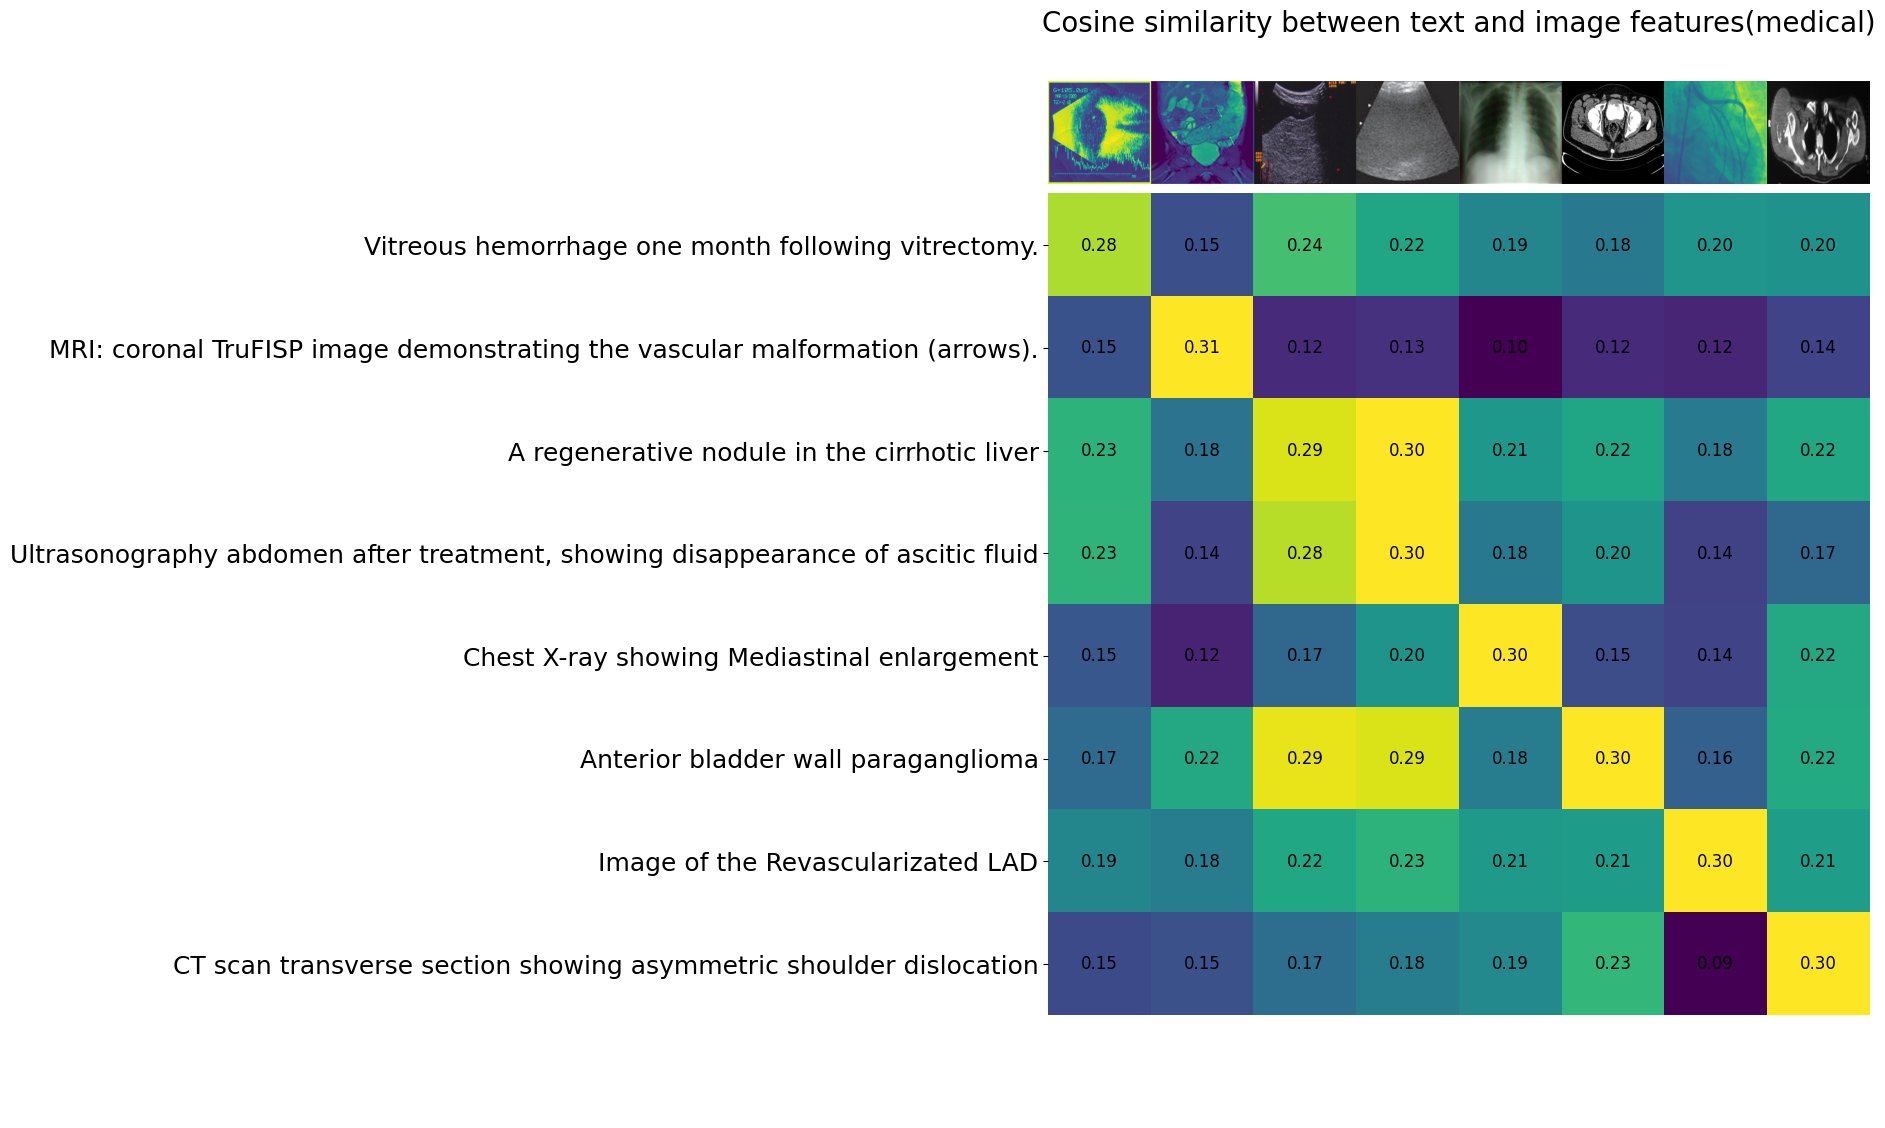

In [34]:
original_images = []
images = []
texts = []
for filename in list(med_descriptions.keys()):
    image = Image.open(os.path.join(root_dir, filename))
    original_images.append(image)
    images.append(preprocess_vit(image))
    texts.append(med_descriptions[filename])
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model_vit.encode_image(image_input).float()
    text_features = model_vit.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(med_descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(medical)", size=20)